In [1]:
!pip install torch
!pip install torchvision
!pip install SummaryWriter
!pip install tensorboard
!pip install scikit-image
!pip install matplotlib
!pip install Lambda
!pip install opencv-python

!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
import os
from posixpath import split
import json
import tarfile
import io
import pickle
import sys
from PIL import Image
from collections import OrderedDict
from pathlib import Path
from collections import defaultdict


import numpy as np
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.utils import draw_bounding_boxes
import torch
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.modeling import PROPOSAL_GENERATOR_REGISTRY
from detectron2.modeling.proposal_generator.rpn import RPN
from detectron2.structures import ImageList
import yaml
from detectron2.layers import ShapeSpec
from detectron2.engine import DefaultTrainer

device = "cuda" if torch.cuda.is_available() else "cpu"
temperature = 1.0
torch.autograd.set_detect_anomaly(True)
data = {}

ERROR: Could not find a version that satisfies the requirement SummaryWriter (from versions: none)
ERROR: No matching distribution found for SummaryWriter
  Using cached PyYAML-5.1-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-events 0.6.3 requires pyyaml>=5.3, but you have pyyaml 5.1 which is incompatible.
fatal: destination path 'detectron2' already exists and is not an empty directory.
matplotlib data path: /home/disi/miniconda3/lib/python3.10/site-packages/matplotlib/mpl-data
CONFIGDIR=/home/disi/.config/matplotlib
interactive is False
platform is linux
CACHEDIR=/home/disi/.cache/matplotlib
Using fontManager instance from /home/disi/.cache/matplotlib/fontlist-v330.json
Loaded

In [2]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ui3_opei
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ui3_opei
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [3]:
from clip import clip

model, preprocess = clip.load("RN50")
model = model.float().to(device).eval()

In [4]:
class RefCOCOgDataset(Dataset):
    def __init__(self, dataset, transform, target_transform, data_dir='dataset/refcocog'):
        super(RefCOCOgDataset, self).__init__()
        self.data_dir = data_dir
        self.transform = transform
        self.target_transform = target_transform
        self.dataset = dataset



    def __getitem__(self, idx):
        data_item = {}
        fname = os.path.join(self.data_dir+'/images/', self.dataset[idx]['image'])
        #fname = os.path.join(self.data_dir+'/images/', list(self.dataset.items())[idx][0])
        image = Image.open(fname).convert('RGB')
        #texts = list(self.dataset.items())[idx][1]
        if self.transform:
            data_item['image'] = self.transform(image).float()
        if self.target_transform:
            data_item['captions'] = clip.tokenize([sent for desc in self.dataset[idx]['captions'] for sent in desc])
        return data_item


    def __len__(self):
        return len(self.dataset)



In [5]:
def get_datasets(refs, train = True):
  ref_data = []
  for val in refs:
    if train:
      if val['split'] == 'train' or val['split'] == 'val':
        ref_data.append(val)
    else:
      if val['split'] == 'test':
        ref_data.append(val)

  '''for i,v in enumerate(datasets):
    training_data, test_data = v'''

  return ref_data


def preProcess_datasets(data_dir, train):
  dataset = {}
  refs = {}
  f = open(f'{data_dir}/annotations/refs(umd).p', 'rb')
  data['refs'] = pickle.load(f)
  if train:
    refs = get_datasets(data['refs'], train=True)
  else:
    refs = get_datasets(data['refs'], train=False)
  instances_file = os.path.join(f'{data_dir}/annotations/instances.json')
  instances = json.load(open(instances_file, 'r'))
  data['images'] = instances['images']
  data['annotations'] = instances['annotations']
  #print(data['refs'][0])
  #print(data['images'][0])
  #print(data['annotations'][0])
  for key,val in enumerate(refs):
    for v in data['images']:
      if(val['image_id'] == v['id']):
        fname = os.path.join(data_dir+'/images/', v['file_name'])
        if os.path.exists(fname):
          dataset[key] = {}
          dataset[key]['image'] = v['file_name']
          dataset[key]['captions'] = [t['sent'] for t in val['sentences']]
          dataset[key]['id'] = val['image_id']
      else:
        continue

  return dataset


  def visualise_result(img, txt):
    resize_image = T.Resize(100)
    img = resize_image(img)
    convert_tensor = T.ToTensor()
    image = convert_tensor(img).to(device)
    image = image.clone().detach()
    image = image.type(torch.ByteTensor).to(device)
    boxs = torch.tensor(w['bbox'],dtype=torch.int).to(device)
    boxes = boxs.reshape([1,4])
    boxes = torchvision.ops.box_convert(boxes, "cxcywh", "xyxy").to(device)
    image = draw_bounding_boxes(image=image, boxes=boxes, width=2, colors=(0,0,255), fill=True).to(device)
    image = image.permute(1,2,0)

In [6]:
def cosine_similarity(tensor1: torch.Tensor, tensor2: torch.Tensor):
  # normalise the image and the text

  tensor1 /= tensor1.norm(dim=-1, keepdim=True)
  tensor2 /= tensor2.norm(dim=-1, keepdim=True)

  # evaluate the cosine similarity between the sets of features
  cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
  similarity = cos(tensor1, tensor2)
  #similarity = (tensor1 @ tensor2.T)

  return similarity.to(device)

In [7]:
def get_cost_function():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

In [8]:
def get_optimizer(model, lr, wd, momentum):
  optimizer = torch.optim.SGD([
      {'params': model.classifier.parameters(), 'lr': lr}
  ], lr=lr / 10, weight_decay=wd, momentum=momentum)

  return optimizer

In [9]:
"""
Applies Batch Normalization over a 1D input (or 2D tensor)

Shape:
  Input: (N, C)
  Output: (N, C)

Input Parameters:
  in_features: number of features of the input activations
  track_running_stats: whether to keep track of running mean and std. (default: True)
  affine: whether to scale and shift the normalized activations. (default: True)
  momentum: the momentum value for the moving average. (default: 0.9)

Usage:
  >>> # with learable parameters
  >>> bn = BatchNorm1d(4)
  >>> # without learable parameters
  >>> bn = BatchNorm1d(4, affine=False)
  >>> input = torch.rand(10, 4)
  >>> out = bn(input)
"""

class BatchNorm1d(torch.nn.Module):
  def __init__(self, in_features, track_running_stats=True, affine=True, momentum=0.9):
    super().__init__()

    self.in_features = in_features
    self.track_running_stats = track_running_stats
    self.affine = affine
    self.momentum = momentum

    if self.affine:
      self.gamma = torch.nn.Parameter(torch.ones(self.in_features, 1))
      self.beta = torch.nn.Parameter(torch.zeros(self.in_features, 1))

    if self.track_running_stats:
      # register_buffer registers a tensor as a buffer that will be saved as part of the model
      # but which does not require to be trained, differently from nn.Parameter
      self.register_buffer('running_mean', torch.zeros(self.in_features, 1))
      self.register_buffer('running_std', torch.ones(self.in_features, 1))

  def forward(self, x):
    # transpose (N, C) to (C, N)
    x = x.transpose(0, 1).contiguous().view(x.shape[1], -1)

    # calculate batch mean
    mean = x.mean(dim=1).view(-1, 1)

    # calculate batch std
    std = x.std(dim=1).view(-1, 1)

    # during training keep running statistics (moving average of mean and std)
    if self.training and self.track_running_stats:
      # no computational graph is necessary to be built for this computation
      with torch.no_grad():
        self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean
        self.running_std = self.momentum * self.running_std + (1 - self.momentum) * std

    # during inference time
    if not self.training and self.track_running_stats:
      mean = self.running_mean
      std = self.running_std

    # normalize the input activations
    x = (x - mean) / std

    # scale and shift the normalized activations
    if self.affine:
      x = x * self.gamma + self.beta

    return x.transpose(0, 1)

In [10]:
"""
Applies Batch Normalization over a 2D or 3D input (4D tensor)

Shape:
  Input: (N, C, H, W)
  Output: (N, C, H, W)

Input Parameters:
  in_features: number of features of the input activations
  track_running_stats: whether to keep track of running mean and std. (default: True)
  affine: whether to scale and shift the normalized activations. (default: True)
  momentum: the momentum value for the moving average. (default: 0.9)

Usage:
  >>> # with learable parameters
  >>> bn = BatchNorm2d(4)
  >>> # without learable parameters
  >>> bn = BatchNorm2d(4, affine=False)
  >>> input = torch.rand(10, 4, 5, 5)
  >>> out = bn(input)
"""

class BatchNorm2d(torch.nn.Module):
  def __init__(self, in_features, track_running_stats=True, affine=True, momentum=0.9):
    super().__init__()

    self.in_features = in_features
    self.track_running_stats = track_running_stats
    self.affine = affine
    self.momentum = momentum

    if self.affine:
      self.gamma = torch.nn.Parameter(torch.ones(self.in_features, 1))
      self.beta = torch.nn.Parameter(torch.zeros(self.in_features, 1))

    if self.track_running_stats:
      # register_buffer registers a tensor as a buffer that will be saved as part of the model
      # but which does not require to be trained, differently from nn.Parameter
      self.register_buffer('running_mean', torch.zeros(self.in_features, 1))
      self.register_buffer('running_std', torch.ones(self.in_features, 1))

  def forward(self, x):
    # transpose (N, C, H, W) to (C, N, H, W)
    x = x.transpose(0, 1)

    # store the shape
    c, bs, h, w = x.shape

    # collapse all dimensions except the 'channel' dimension
    x = x.contiguous().view(c, -1)

    # calculate batch mean
    mean = x.mean(dim=1).view(-1, 1)

    # calculate batch std
    std = x.std(dim=1).view(-1, 1)

    # keep running statistics (moving average of mean and std)
    if self.training and self.track_running_stats:
      with torch.no_grad():
        self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * mean
        self.running_std = self.momentum * self.running_std + (1 - self.momentum) * std

    # during inference time
    if not self.training and self.track_running_stats:
      mean = self.running_mean
      std = self.running_std

    # normalize the input activations
    x = (x - mean) / std

    # scale and shift the normalized activations
    if self.affine:
      x = x * self.gamma + self.beta

    return x.view(c, bs, h, w).transpose(0, 1)


In [11]:
def training_step(net, data_loader, optimizer, cost_function, device='cuda'):
    samples = 0.0
    cumulative_loss = 0.0
    cumulative_accuracy = 0.0

    # set the network to training mode
    net = net.float()
    net.train()

  # iterate over the training set
    for batch_idx, batch in enumerate(data_loader):

      #load data into GPU
      batch['image'] = batch['image'].to(device)
      batch['captions'] = batch['captions'].to(device)
        # forward pass
      outputs, targets = net(batch)

      # loss computation
      loss = cost_function(outputs, targets)
      #print('loss')
      #print(loss)
      # backward pass
      loss.backward()

      # parameters update
      optimizer.step()

      # gradients reset
      optimizer.zero_grad()

      # fetch prediction and loss value
      samples += batch['captions'].shape[0]
      cumulative_loss += loss.item()

      #compute accuracy

      predicted = torch.max(outputs, 1).values
      target = torch.max(outputs, 1).values
      cumulative_accuracy += predicted.eq(target).sum().item()

    #print(calculate_accuracy(outputs, targets))
    return cumulative_loss / samples, (cumulative_accuracy / samples) * 100

def test_step(net, data_loader, cost_function, device='cuda'):
    samples = 0.0
    cumulative_loss = 0.0
    cumulative_accuracy = 0.0

    net = net.float()
    # set the network to evaluation mode
    net.eval()

    # disable gradient computation (we are only testing, we do not want our model to be modified in this step!)
    with torch.no_grad():
        # iterate over the test set

      for batch_idx, batch in enumerate(data_loader):

        #load data into GPU
        batch['image'] = batch['image'].to(device)
        batch['captions'] = batch['captions'].to(device)

        # forward pass
        outputs, targets = net(batch)

        # loss computation
        loss = cost_function(outputs, targets)
        #print(loss)
        # fetch prediction and loss value
        samples += batch['captions'].shape[0]
        cumulative_loss += loss.item() # Note: the .item() is needed to extract scalars from tensors


        #_, predicted = outputs.max(1)
        predicted = torch.max(outputs, 1).values
        target = torch.max(targets, 1).values

        # compute accuracy

        predicted = torch.max(outputs, 1).values
        target = torch.max(outputs, 1).values
        cumulative_accuracy += predicted.eq(target).sum().item()

        #print(calculate_accuracy(outputs, targets))

    return cumulative_loss / samples, (cumulative_accuracy / samples) * 100

In [12]:
class ProjectionHead(torch.nn.Module):
    def __init__(
        self,
        embedding_dim,
        in_features = 1024,
        out_features = 1024,
        bias=False
    ):
        super().__init__()
        self.classifier = torch.nn.Sequential(
          torch.nn.Linear(in_features, out_features, bias=bias),
          torch.nn.GELU(),
          torch.nn.Linear(out_features, out_features, bias=bias),
          torch.nn.Dropout(0.1),
          torch.nn.BatchNorm1d(1024),
        )

    def forward(self, x):
        projected = self.classifier(x)

        return x

In [13]:
class CustomCLIP(torch.nn.Module):
  def __init__(self, num_classes: int = 10, bias=False):
    super().__init__()
    model, _ = clip.load("RN50")
    in_features = 1024
    out_features = 1024
    embedding_dim = ''
    # take the visual encoder of CLIP
    # we also convert it to be 32 bit (by default CLIP is 16)
    self.encoder = model.visual.float()
    self.text_encoder = self.encode_text

    self.projection = ProjectionHead(embedding_dim)
    #self.classifier = torch.nn.Linear(1024, num_classes)
    # add a bottleneck
    self.classifier = torch.nn.Sequential(
      torch.nn.Linear(in_features, out_features, bias=bias),
      torch.nn.GELU(),
      torch.nn.Linear(out_features, out_features, bias=bias),
      torch.nn.Dropout(0.1),
      torch.nn.BatchNorm1d(1024),
    )

  def encode_text(self, text):
      x = model.token_embedding(text).float()
      x = x + model.positional_embedding.float()
      x = x.permute(1, 0, 2)  # NLD -> LND
      #x = x.type(torch.float16).to(device)
      x = model.transformer(x).float()
      x = x.permute(1, 0, 2)  # LND -> NLD
      x = model.ln_final(x).float()

      # x.shape = [batch_size, n_ctx, transformer.width]
      # take features from the eot embedding (eot_token is the highest number in each sequence)
      x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)] @ model.text_projection

      return x


  def forward(self, batch):
    x = batch['image']
    x = self.encoder(x)
    x = self.classifier(x)
    y = batch['captions']
    y = self.text_encoder(y)
    y = self.classifier(y)

    target_len = y.size(0) - x.size(0)
    x = F.pad(x, (0,0,0,target_len), value=0)

    x_similarity = x @ x.T
    y_similarity = y @ y.T


    targets = F.softmax(
      (x_similarity + y_similarity) / 2 * temperature, dim=-1
    )


    outputs =  (x @ y.T) / temperature



    return outputs, targets

In [14]:
def pad_sequence(batch):
  return torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0)
def my_collate_fn(batch):
  '''captions = captions.squeeze(0).detach().cpu().numpy()
  captions = captions[:,:,0]
  print(captions.shape)
  captions = captions.permute(2,1,0)
  print(captions.shape)
  captions = captions.float().mean(2)'''
  return {
      'image': torch.stack([x['image'] for x in batch]),
      'captions': torch.cat([x['captions'] for x in batch], dim=0)
      }


def get_data(data_dir, batch_size, transform=True, target_transform=True, test_batch_size=2):


    if transform:
        # convert the PIL images to Tensors
        transform = preprocess
    else:
          # prepare data transformations and then combine them sequentially
        transform = T.Compose([torchvision.transforms.ToTensor()])
    if target_transform:
        target_transform = T.Compose([
                                 lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)])
    else:
        target_transform = None

  # load data
    dataset = preProcess_datasets(data_dir, train=True)
    full_training_data = RefCOCOgDataset(dataset=dataset, transform=transform, target_transform=target_transform, data_dir=data_dir)

    test_dataset = preProcess_datasets(data_dir, train=False)
    test_data = RefCOCOgDataset(dataset=test_dataset, transform=transform, target_transform=target_transform, data_dir=data_dir)



    evens = list(range(0, len(full_training_data), 2))
    #training_data2 = torch.utils.data.Subset(full_training_data, evens)
    training_data2 = torch.utils.data.Subset(full_training_data, range(50))
    #test_data2 = torch.utils.data.Subset(test_data, range())

  # create train and validation splits
    num_samples = len(training_data2)
    training_samples = int(num_samples * 0.5 + 1)
    validation_samples = num_samples - training_samples

    training_data, validation_data = torch.utils.data.random_split(training_data2, [training_samples, validation_samples])

  # initialize dataloaders_collate
    train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True, num_workers=2, collate_fn=my_collate_fn)
    val_loader = torch.utils.data.DataLoader(validation_data, test_batch_size, shuffle=False, num_workers=2, collate_fn=my_collate_fn)
    test_loader = torch.utils.data.DataLoader(test_data, test_batch_size, shuffle=False, num_workers=2, collate_fn=my_collate_fn)
    #test_loader = torch.utils.data.DataLoader(test_data2, test_batch_size, shuffle=False, num_workers=2, collate_fn=my_collate_fn)

    print(len(training_data))

    print(len(validation_data))
    print(len(test_data))

    # pre-train model on zero-shot transfer learning
    #test_accuracy = test_step_zero_shot_clip(model, test_loader, texts_z)


    # evaluate accuracy on zero-shot learning

    #print("Test accuracy {:.2f}".format(test_accuracy))

    return train_loader, val_loader, test_loader


In [15]:
# tensorboard logging utilities
def log_values(writer, step, loss, accuracy, prefix):
  writer.add_scalar(f"{prefix}/loss", loss, step)
  writer.add_scalar(f"{prefix}/accuracy", accuracy, step)

In [16]:
modified_model = CustomCLIP(num_classes=10).to(device)

In [17]:
# main funcition
def main(
      root='/content/dataset/refcocog/',
      data_dir='dataset/refcocog',
      batch_size=2,
      num_classes=10,
      learning_rate=0.000000000000001,
      weight_decay=0.000001,
      momentum=0.9,
      #epochs=10,
      epochs=3
    ):
  writer = SummaryWriter(log_dir="runs/exp1")
  global test_loader
  # train clip on zero-shot learning and instantiates dataloaders
  train_loader, val_loader, test_loader = get_data(data_dir=data_dir, batch_size=batch_size, transform=True, target_transform=True, test_batch_size=2)
  #train_loader, test_loader = get_data(data_dir=data_dir, batch_size=batch_size, transform=True, target_transform=True, test_batch_size=32)
  #dataset = get_data(data_dir=data_dir, batch_size=batch_size, transform=True, test_batch_size=None)

  # instantiate the network and move it to the chosen device (GPU)


  # instantiate the optimizer
  optimizer = get_optimizer(modified_model, learning_rate, weight_decay, momentum)

  # define the cost function
  cost_function = get_cost_function()

  # evaluate accuracy of modified model on zero-shot learning
  #test_accuracy = test_step_zero_shot_clip(model, test_loader, texts_z).to(device)

  #print(cosine_similarity(images_z, texts_z))
  #print("Test accuracy {:.2f}".format(test_accuracy))

  # computes evaluation results before training
  '''print('Before training:')
  train_loss, train_accuracy = test_step(modified_model, train_loader, cost_function)
  val_loss, val_accuracy = test_step(modified_model, val_loader, cost_function)
  test_loss, test_accuracy = test_step(modified_model, test_loader, cost_function)

  # log to TensorBoard
  log_values(writer, -1, train_loss, train_accuracy, "train")
  log_values(writer, -1, val_loss, val_accuracy, "validation")
  log_values(writer, -1, test_loss, test_accuracy, "test")

  print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
  print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
  print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
  print('-----------------------------------------------------')'''

  # for each epoch, train the network and then compute evaluation results
  for e in range(epochs):

    train_loss, train_accuracy = training_step(modified_model, train_loader, optimizer, cost_function)
    val_loss, val_accuracy = test_step(modified_model, val_loader, cost_function)

    # logs to TensorBoard
    log_values(writer, e, val_loss, val_accuracy, "Validation")

    print('Epoch: {:d}'.format(e+1))
    print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('-----------------------------------------------------')

    # compute final evaluation results
    print('After training:')
    train_loss, train_accuracy = test_step(modified_model, train_loader, cost_function)
    val_loss, val_accuracy = test_step(modified_model, val_loader, cost_function)
    test_loss, test_accuracy = test_step(modified_model, test_loader, cost_function)

    # log to TensorBoard
    log_values(writer, epochs, train_loss, train_accuracy, "train")
    log_values(writer, epochs, val_loss, val_accuracy, "validation")
    log_values(writer, epochs, test_loss, test_accuracy, "test")

    print('\tTraining loss {:.5f}, Training accuracy {:.2f}'.format(train_loss, train_accuracy))
    print('\tValidation loss {:.5f}, Validation accuracy {:.2f}'.format(val_loss, val_accuracy))
    print('\tTest loss {:.5f}, Test accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

  # closes the logger
  writer.close()


In [18]:
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:<1024>"
os.environ["CUDA_LAUNCH_BLOCKING"]="1"

In [19]:
!pip install scikit-learn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def calculate_accuracy(outputs, targets):

  # import some data to play with
  iris = datasets.load_iris()
  X = iris.data
  y = iris.target

  class_names = iris.target_names
  labels, counts = np.unique(y, return_counts=True)

  cm = confusion_matrix(targets, outputs)


  ConfusionMatrixDisplay.from_predictions(outputs, targets)
  plt.show()
  accuracy = np.sum(np.diagonal(cm)) / np.sum(cm)
  return accuracy

In [20]:
main()

26
24
5023
Epoch: 1
	Training loss 0.03724, Training accuracy 100.00
	Validation loss 0.03071, Validation accuracy 100.00
-----------------------------------------------------
After training:
	Training loss 0.03156, Training accuracy 100.00
	Validation loss 0.03071, Validation accuracy 100.00
	Test loss 0.03256, Test accuracy 100.00
-----------------------------------------------------
Epoch: 2
	Training loss 0.03649, Training accuracy 100.00
	Validation loss 0.03883, Validation accuracy 100.00
-----------------------------------------------------
After training:
	Training loss 0.04031, Training accuracy 100.00
	Validation loss 0.03883, Validation accuracy 100.00
	Test loss 0.04298, Test accuracy 100.00
-----------------------------------------------------
Epoch: 3
	Training loss 0.03629, Training accuracy 100.00
	Validation loss 0.06974, Validation accuracy 100.00
-----------------------------------------------------
After training:
	Training loss 0.07638, Training accuracy 100.00
	Va

In [21]:
#@PROPOSAL_GENERATOR_REGISTRY.register()
class RPNGenerator(RPN):
    """
    RPNGenerator RPN subnetwork.
    """

    def __init__(self, cfg, input_shape):
        super(RPNGenerator, self).__init__(cfg, input_shape)
        self.cfg = cfg
        self.num_branch = cfg.MODEL.TRIDENT.NUM_BRANCH
        self.trident_fast = cfg.MODEL.TRIDENT.TEST_BRANCH_IDX != -1

    def forward(self, images, features, gt_instances=None):
        """
        See :class:`RPN.forward`.
        """
        num_branch = self.num_branch if self.training or not self.trident_fast else 1
        # Duplicate images and gt_instances for all branches in TridentNet.
        all_images = ImageList(
            torch.cat([images.tensor]), images.image_sizes
        )
        #all_gt_instances = gt_instances * num_branch if gt_instances is not None else None
        proposals, losses = super(RPNGenerator, self).forward(all_images, features)

        cfg_yaml = yaml.dump(self.cfg)
        rpn_name = 'rpn_proposals_clip_detectron2.yaml'
        rpn_file = os.path.join(rpn_name)
        yaml.dump(
            dict(proposals, losses), rpn_file
        )
        #logger.info('Wrote RPN proposals to {}'.format(os.path.abspath(rpn_file)))

        return rpn_file

In [22]:
#!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
#im = cv2.imread("./input.jpg")
def draw_bbx(im):
  cfg = get_cfg()
  #cv2_imshow(im)
  '''cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
  cfg.DATASETS.TRAIN = ("balloon_train",)
  cfg.DATASETS.TEST = ()'''
  cfg.DATALOADER.NUM_WORKERS = 2
  #cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
  cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
  cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
  cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
  cfg.SOLVER.STEPS = []        # do not decay learning rate
  cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
  #cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
  # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

  os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
  trainer = DefaultTrainer(cfg)
  trainer.resume_or_load(resume=False)
  trainer.train()
  input_shape=ShapeSpec(channels=1024)
  # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library

  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
  rpn_generator = RPNGenerator(cfg, input_shape)
  rpn_file = rpn_generator(data['images'], image_embeddings)
  cfg.merge_from_file(rpn_file)
   # set threshold for this model
  # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
  cfg.MODEL.WEIGHTS = rpn_file
  predictor = DefaultPredictor(cfg)
  outputs = predictor(im)

  v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(data['images']), scale=1.2)
  out = v.draw_instance_predictions(outputs["instances"].to(device))
  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.rcParams['figure.figsize'] = [20, 10]
  plt.imshow(out.get_image()[:, :, ::-1])
  plt.show()
  #cv2_imshow(out.get_image()[:, :, ::-1])

In [25]:
def get_img_embeddings(loader, model):

  test_image_embeddings = []

  for idx, batch in enumerate(loader):
    batch['image'] = batch['image'].to(device)
    image_features = model.encoder(batch['image']).to(device)
    image_embeddings = model.projection(image_features)
    test_image_embeddings.append(image_embeddings)

  test_image_embeddings = torch.cat(test_image_embeddings)

  return test_image_embeddings


def inference(model, query, image_filenames, n):

    model.eval()
    global image_embeddings

    tokenized_query = clip.tokenize([query]).to(device)
    '''batch = {
        key: torch.tensor(values).to(device)
        for key, values in encoded_query.items()
    }'''


    with torch.no_grad():

      image_embeddings = get_img_embeddings(test_loader, model).to(device)
      text_features = model.text_encoder(tokenized_query).to(device)
      text_embeddings = model.projection(text_features)

      image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
      text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
      dot_similarity = text_embeddings_n @ image_embeddings_n.T

      #print(dot_similarity.squeeze(0))
      val, index = torch.topk(dot_similarity.squeeze(0), n)
      found_match = image_filenames[index]

      plt.figure(1)
    #for match, ax in zip(matches, axes.flatten()):
      image = cv2.imread(f"{'dataset/refcocog/images'}/{found_match['file_name']}")
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      imgplot = plt.imshow(image)
      plt.show()
      #draw_bbx(image)
      




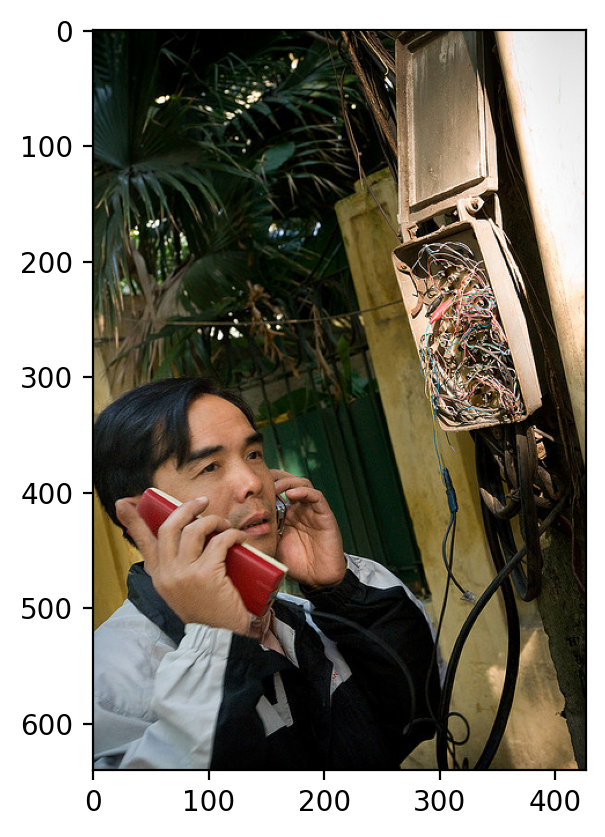

[06/30 12:41:12 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

AssertionError: ()

In [28]:
inference(modified_model,
             query="tree",
             image_filenames=data['images'], n=1)

In [ ]:
#feature_extractor_model = torch.hub.load('detectron2/detectron2', 'detectron2', pretrained=True)

In [ ]:
import torch
a = torch.randn(1, 3)
print(a)
predicted = torch.max(a,1).values()
print(predicted)
predicted = torch.max(a).item()
print(predicted)

#cumulative_accuracy += predicted.eq(targets).sum().item()
c = torch.tensor([[1, 2], [3, 4]]).eq(torch.tensor([[1, 1], [4, 4]])).sum().item()
print(c)